## Import

In [37]:
import numpy as np

from mpmath import mp
from mpmath import cosh, sinh, tanh, exp, sqrt

from gwr_inversion import gwr
M_value = 32

import matplotlib.pyplot as plt

## Function and expression declarations

In [38]:
#Declare the expressions of the kernel, A and eta
def ker_sy (s, Oh, Bo, k, lbda):
    return 2*Oh/s*k*(k-lbda*tanh(k)) - Oh/s*(4*lbda*k*sinh(k)*(k*exp(-lbda)
            *(k*cosh(k)+lbda*sinh(k))-(k**2+lbda**2))+(k**2+lbda**2)**2
            *sinh(lbda))/(2*k*cosh(k)*(k*cosh(k)*sinh(lbda)-lbda*sinh(k)*cosh(lbda)))
            
def eta_sy (s, Oh, k, omega2, Kern):
    return 1/s*(1-omega2/(s**2+4*Oh*k**2*s+omega2+2*Oh*k**2*s*Kern))
def ALaplace_sy (s, Oh, k, lbda, omega2, z, Kern):
    return 1/sinh(lbda)*(-(-2*k*lbda*sinh(k)+(k**2+lbda**2)*sinh(lbda))
             *sinh(lbda*z)/(k*(-lbda*cosh(lbda)*sinh(k)+k*cosh(k)*sinh(lbda)))
             +2*sinh(lbda*(1+z)))*(-omega2/(s**2+4*Oh*k**2*s+omega2+2*Oh*k**2*s*Kern))

#Reduce the expressions as functions of s and of the parameters Oh, Bo and k
def freeSurfaceLaplace(s, Oh, Bo, k):
    lbda = sqrt(k**2 + s/Oh)
    omega2 = (Bo+k**2)*k*tanh(k)
    ker = ker_sy (s, Oh, Bo, k, lbda)
    return eta_sy(s, Oh, k, omega2, ker)

def vortiLaplace(s, z, Oh, Bo, k):
    lbda = sqrt(k**2 + s/Oh)
    omega2 = (Bo+k**2)*k*tanh(k)
    ker = ker_sy (s, Oh, Bo, k, lbda)
    return k*ALaplace_sy (s, Oh, k, lbda, omega2, z, ker)

#Inverse the Laplace transfrom and return functions of t and of the parameters Oh, Bo and k
def freeSurface(t, Oh, Bo, k):
    return gwr(lambda s: freeSurfaceLaplace(s, Oh, Bo, k), t, M = 32)

def vorti(t, z, Oh, Bo, k):
    return gwr(lambda s: vortiLaplace(s, z, Oh, Bo, k), t, M = 32)


## Main function

In [39]:
def plotComparison(Ohnumb, Bonumb, knumb, nbOfrelax):
    Oh = mp.mpmathify(Ohnumb)
    Bo = mp.mpmathify(Bonumb)
    k = mp.mpmathify(knumb) 
    
    #Resolution functions with numerical Laplace Transform GWR. Oh_, Bo_ and k_ must have been defined before
    def eta(t):
        return float(freeSurface(t, Oh, Bo, k))
    
    def omega(t, z_):    
        return float(vorti(t, z_, Oh, Bo, k))
    
    #determine the maximal value of vorticity
    t_all = np.linspace(0.03, 3., 100)/Oh
    z_top = mp.mpmathify('-0.99')
    vortmax = [abs(omega(t, z_top)) for t in t_all]
    maxv = max(np.array(vortmax))
    
    #Spatial and time resolutions
    tau_relax = float(3*(Oh/(k**2*Bo+k**4)))
    timesOfInterest = np.array([0.1, 0.2, 0.5, 1])*nbOfrelax*tau_relax
    z_all = np.linspace(-1, 0, 100)
    t_all_eta = np.linspace(0.01, nbOfrelax, 100) * tau_relax
    
    #solve the equation on omega with Cortelezzi model and lubrication
    sampled_omega = np.array([[2*i+omega(timesOfInterest[i], z)/maxv
        for i in range(4)] for z in z_all])
    sampled_omega_lub = np.array([[2*i+float(k**3/Oh+k*Bo/Oh)*(-z)
        *np.exp(-timesOfInterest[i]/tau_relax)/maxv
        for i in range(4)] for z in z_all])
    sampled_t = t_all_eta/tau_relax
    sampled_eta = [eta(t) for t in t_all_eta]
    sampled_eta_lub = [np.exp(-t/tau_relax) for t in t_all_eta]
    
    ### Figures ###
    plt.rcParams['text.usetex'] = True
    plt.rcParams['text.latex.preamble'] = [r'\usepackage[squaren,Gray]{SIunits}',
                                           r'\usepackage{nicefrac}']
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'cm'
    #font size
    plt.rc('font', size=28)  # general font size
    plt.rc('axes', labelsize=28, titlesize=28)
    plt.rc('lines', markersize=9, markeredgewidth=0., linewidth=1.5)
    plt.rc('legend', frameon=False, fancybox=False, numpoints=1, markerscale=1, 
           fontsize=16, handlelength=0.6, handletextpad=0.6, labelspacing=0.3)
    plt.rc('xtick',  labelsize=22, direction='in', bottom='true', top='true')
    plt.rc('ytick',  labelsize=22, direction='in', left='true', right='true')
    
    
    plt.rc('figure', figsize=[6, 6])
    plt.figure()
    plt.xlabel(r'Time (in $\tau_{relax}$ units)')
    plt.ylabel("Relative wave amplitude")
    plt.xlim([0,nbOfrelax])
    plt.ylim([0,1])
    plt.rc('legend', loc='best')
    
    plt.plot(sampled_t,sampled_eta, 'black', label = r'Cortelezzi \& Prosperetti')
    plt.plot(sampled_t,sampled_eta_lub, 'gray', label = 'Lubricaion theory')
    plt.legend()
    
    
    plt.rc('figure', figsize=[12, 6])
    plt.figure()
    plt.xlabel('Scaled vorticity')
    plt.ylabel('depth z')
    plt.xlim([-1,7])
    plt.ylim([-1,0])
    plt.rc('legend', loc='best')
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    
    for i in range(4):
        plt.plot(sampled_omega[:,i], z_all, 'r', linewidth=1)
        plt.plot(2*i*np.ones(100), z_all, 'r', linewidth=1)
        plt.fill_betweenx(z_all, sampled_omega[:,i], 2*i, color = 'red', alpha=0.20)
        plt.plot(sampled_omega_lub[:,i],z_all, c = 'gray', linewidth=1, linestyle='dashed')
   

### Oh = 10, Bo = 0.001, k = 0.1

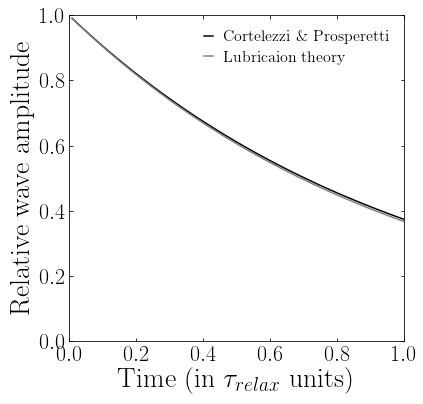

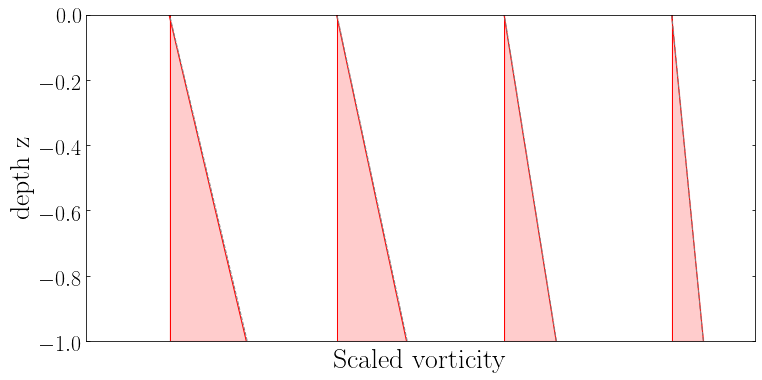

In [40]:
plotComparison(10, 0.001, 0.1, 1) 

### Oh = 10, Bo = 0.001, k = 1

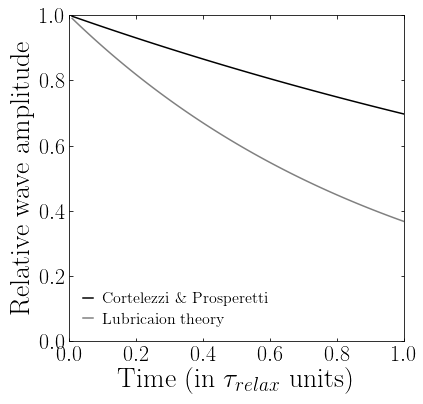

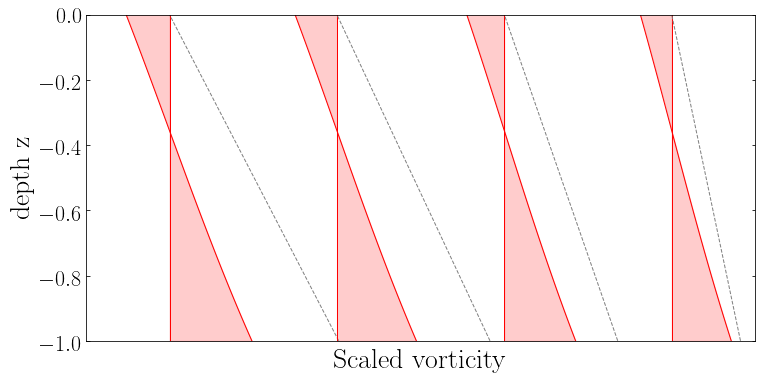

In [41]:
plotComparison(10, 0.001, 1., 1)

### Oh = 0.01, Bo = 0.001, k = 0.1

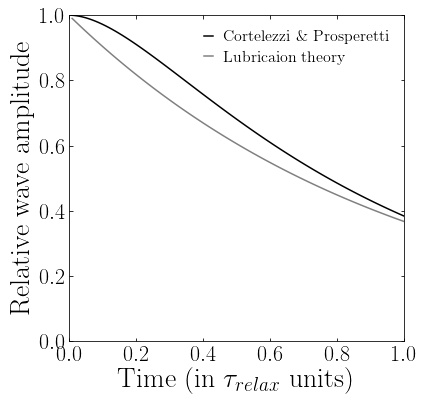

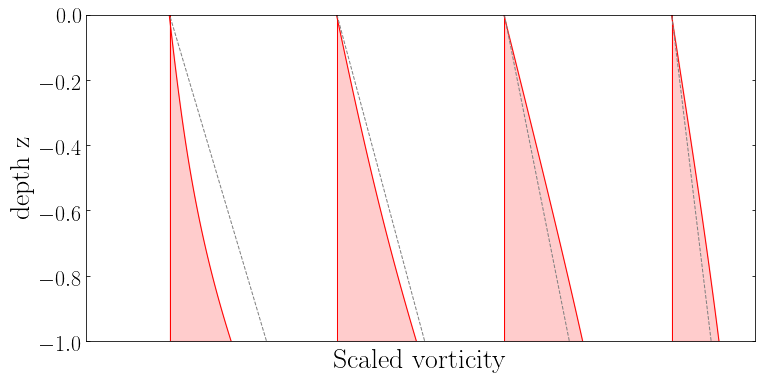

In [42]:
plotComparison(0.01, 0.001, 0.1, 1)

### Oh = 0.01, Bo = 0.001, k = 1

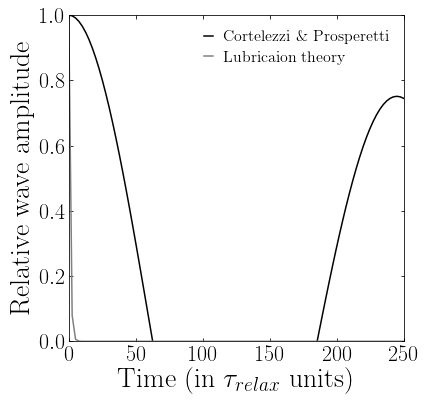

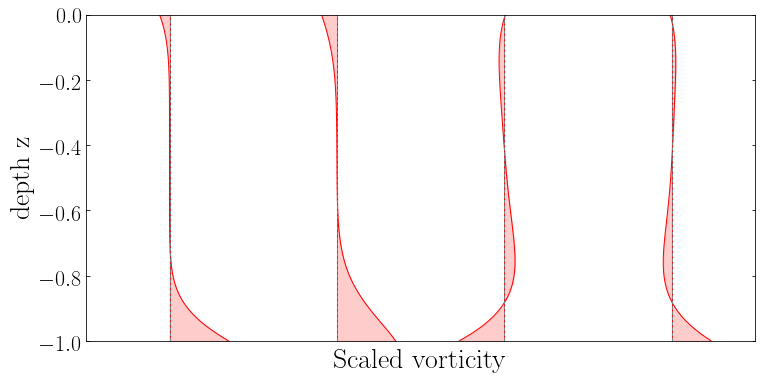

In [43]:
plotComparison(0.01, 0.001, 1., 250)